## pyHAIL Static Image Creator

This code uses pyHAIL and creates static images rather than animations.

In [43]:
from __future__ import print_function
import warnings
import warnings
warnings.filterwarnings('ignore')

"""
MESH sub-module of pyhail
Contains the single pol MESH retrieval for gridded radar data.
Required reflectivity and temperature data.
Joshua Soderholm - 15 June 2018
"""
import os

import netCDF4
import numpy as np
import pyart
import pyhail as ph
from pyhail import common
from pyhail import mesh


from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from time import time
from datetime import datetime
from dateutil import tz
import os
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cartopy.io.shapereader as shpreader
from skewt import SkewT
import glob
from glob import glob
from botocore.handlers import disable_signing
from matplotlib.animation import FuncAnimation

import cartopy
from datetime import datetime
import cartopy.io.shapereader as shpreader
from matplotlib.animation import FuncAnimation
import glob
from dateutil import tz

# from cpol_processing import processing as cpol_prc
from pyhail import hsda, hdr, mesh, common

In [2]:
# Obtaining radar scans...
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    for key in keys:
        if 'MDM' in key:
            keys.remove(key)
    print(keys)
    return aws_radar, keys

In [3]:
aws_radar, keys = get_radar_scan(station='KLOT', date='2019/05/27', key_index=-400) 
out_path_dir = 'home/amedendorp/Desktop/april182013'

['2019/05/27/KLOT/KLOT20190527_000114_V06', '2019/05/27/KLOT/KLOT20190527_000759_V06', '2019/05/27/KLOT/KLOT20190527_001453_V06', '2019/05/27/KLOT/KLOT20190527_002158_V06', '2019/05/27/KLOT/KLOT20190527_002851_V06', '2019/05/27/KLOT/KLOT20190527_003550_V06', '2019/05/27/KLOT/KLOT20190527_004240_V06', '2019/05/27/KLOT/KLOT20190527_004945_V06', '2019/05/27/KLOT/KLOT20190527_005649_V06', '2019/05/27/KLOT/KLOT20190527_010348_V06', '2019/05/27/KLOT/KLOT20190527_011054_V06', '2019/05/27/KLOT/KLOT20190527_011753_V06', '2019/05/27/KLOT/KLOT20190527_012451_V06', '2019/05/27/KLOT/KLOT20190527_013157_V06', '2019/05/27/KLOT/KLOT20190527_013856_V06', '2019/05/27/KLOT/KLOT20190527_014602_V06', '2019/05/27/KLOT/KLOT20190527_015301_V06', '2019/05/27/KLOT/KLOT20190527_020006_V06', '2019/05/27/KLOT/KLOT20190527_020701_V06', '2019/05/27/KLOT/KLOT20190527_021405_V06', '2019/05/27/KLOT/KLOT20190527_022111_V06', '2019/05/27/KLOT/KLOT20190527_022816_V06', '2019/05/27/KLOT/KLOT20190527_023521_V06', '2019/05/2

In [82]:
nk = keys[188] #:210
nk

'2019/05/27/KLOT/KLOT20190527_185257_V06'

In [83]:
localfile = tempfile.NamedTemporaryFile()
aws_radar.download_file(keys[0], localfile.name)
radar = pyart.io.read(localfile.name)
radar.fields.keys()

dict_keys(['cross_correlation_ratio', 'differential_phase', 'differential_reflectivity', 'reflectivity', 'spectrum_width', 'velocity'])

In [84]:
# Turning the data into grid data and saving it to a folder...
# If the grids are already created, there is no need to run this code block again.
def get_grid(aws_radar, keys):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(nk, localfile.name)
    radar = pyart.io.read(localfile.name)
    # Create rainfall rate field
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radar.fields['reflectivity']['data'][:, -10:] = np.ma.masked

    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('reflectivity')
    grid = pyart.map.grid_from_radars(
            (radar, ), grid_shape=(16, 300, 300),
            grid_limits=((0, 15000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['reflectivity'], weighting_function='Barnes2',
            gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=500., gatefilters=(gatefilter, ))
    del radar
    return grid

for num,key in enumerate(nk):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join('/home/amedendorp/Desktop/MESH_grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid
# If the code encounters a .tar file or any other unknown file, it will stop running.
# Every grid created before that will be preserved.

saving grid 0
saving grid 1


KeyboardInterrupt: 

In [85]:
from glob import glob
files = glob('/home/amedendorp/Desktop/MESH_grid_*')
files.sort()

In [86]:
reader = shpreader.Reader('/home/amedendorp/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

2019-05-27 18:52:57.119000


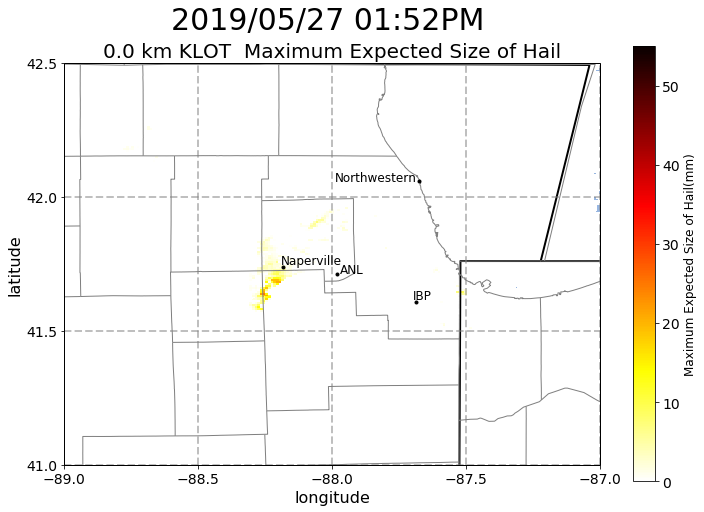

In [87]:
# This code was created using a modified version of pyART. The only thing that will change versus default
# pyART is the thickness and color of the lat and lon lines, and the county and state outlines.
plt.rcParams.update({'axes.titlesize': '20'})
fig = plt.figure(figsize=[12,8])  
radar = pyart.io.read_grid('/home/amedendorp/Desktop/MESH_grid_000.nc')

# Converting the default UTC time to local time...
# Converts to 24-hour time. No AM or PM.
utc = netCDF4.num2date(radar.time['data'][0],
                   radar.time['units'])
print(str(utc))
z = datetime.strptime(str(utc), '%Y-%m-%d %H:%M:%S.%f')

from_zone = tz.tzutc()
to_zone = tz.tzlocal()
z = z.replace(tzinfo=from_zone)
central = z.astimezone(to_zone)
t = datetime.strftime(central, '%Y/%m/%d')
m = datetime.strftime(central, ' %I:%M%p')


title = ( str(radar.z['data'][0]/1000) + ' km ' + 'KLOT ' + ' Maximum Expected Size of Hail')
hail = mesh.main(grid=radar, ref_name='reflectivity', 
                 snd_input='/home/amedendorp/Desktop/Sounding.nc', 
                 sonde_temp='temp', sonde_height='height')

projection = ccrs.PlateCarree()

#ax = plt.axes(projection=projection)

# Plot site locations...
ANL_lon, ANL_lat = -87.981810, 41.713969 
NW_lon, NW_lat = -87.675885, 42.057888
Naperville_lon, Naperville_lat = -88.181798, 41.738107
IBP_lon, IBP_lat = -87.687151, 41.606367

display = pyart.graph.GridMapDisplay(hail)
display.plot_grid('MESH', level= 0, lat_lines=np.arange(41, 43, .5),
                   lon_lines=np.arange(-89, -86.5, .5), cmap='hot_r', vmax=55, vmin=0,
                  projection=projection, embelish = True)

ax = plt.gca()

myt =   t + m

ax.set_title(title)
plt.plot([ANL_lon], [ANL_lat], color='black', marker= '.',)
plt.plot([NW_lon], [NW_lat], color='black', marker= '.')
plt.plot([Naperville_lon], [Naperville_lat], color='black', marker= '.')
plt.plot([IBP_lon], [IBP_lat], color='black', marker= '.')

# Plot names of sites:
plt.text(ANL_lon + 0.01, ANL_lat - 0., 'ANL', horizontalalignment='left')
plt.text(NW_lon - 0.01, NW_lat - 0, 'Northwestern', horizontalalignment='right')
plt.text(Naperville_lon - 0.01, Naperville_lat + 0.01, 'Naperville', horizontalalignment='left')
plt.text(IBP_lon - 0.01, IBP_lat + 0.01, 'IBP', horizontalalignment='left')
plt.text(-88.6, 42.5, t + m + ' \n', horizontalalignment='left', fontsize = 30)


ax.tick_params(labelsize=14) 
plt.rcParams['xtick.labelsize']=14
plt.rcParams['font.size']=12
plt.rcParams['ytick.labelsize']=14
plt.ylabel("latitude", fontsize = 16)
plt.xlabel("longitude", fontsize = 16)

#plt.title(label= str(radar.z['data'][0]/1000) + ' km ' + 'KLOT ' + ' Maximum Expected Size of Hail')

#del radar, display
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.add_feature(cfeature.LAKES, zorder=.5)


# Match the frames to the amount of grids
#sat_anim = FuncAnimation(fig, rr_animation, frames=1)
#sat_anim.save('/home/amedendorp/Desktop/pyhailtest2.png',
#              writer='imagemagick', fps=3)
#plt.close(fig)
plt.savefig('/home/amedendorp/Desktop/Hail_for_Poster.png')
